<center><h1>QBUS6850 - Machine Learning for Business</h1></center>

# Tutorial 7 - Advanced Classification Techniques I


### Objectives:

•	To learn how to build Decision Trees;

•	To learn how to use decision tree model from scikit;

•	To learn how to visualising trees or extract rules

Note: To complete all the tasks in this tutorial, you need install Graphviz and Pydotplus.  See the last section for information

## Decision Tree Mechanics<a id='mechanics'></a>

Almost all decision trees algorithms work on the same shared principle. That is, recursively partition the data to maximise the purity of classes in each partition. Under this principle eventually the leaf nodes (partitions) will be pure or close to pure.

Below I will demonstrate how this principle works in practice through a naive implementation of ID3 that builds a single layer tree i.e. a single root node and two leaf nodes. In such a shallow tree we need only compute one split of the data so we can omit the recursive component.

    ID3_ (Iterative Dichotomiser 3) was developed in 1986 by Ross Quinlan. The algorithm creates a multiway tree, finding for each node (i.e. in a greedy manner) the categorical feature that will yield the largest information gain for categorical targets.
*from http://scikit-learn.org/stable/modules/tree.html*

Refer to Section "1.10.7. Mathematical formulation" to see the mathematical details that used by Python. 

To build our single layer decision tree we only need to calculate one partition. This partition should yield the purest partition. In the case of categorical features this is easy, we can produce $N$ candidate splits where $N$ is the total number of all categories in all features. Then we need to calculate the impurity or information gain for
each split and choose the best split. In the case of numerical features things are more complicated (See later "customer default" example).

### Example: Classifying the customer purchase data in lecture 6
#### Try the “Lecture06_Example01_Updated.py” cod by yourself and generate the results on slide 41 and 42. 
Pre-process the data

In [1]:
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from __future__ import division
import pandas as pd
import numpy as np

purchase_df = pd.read_csv("Lecture6_Data.csv")

purchase_df_x = pd.get_dummies(purchase_df.iloc[:, 1:-1])

le = LabelEncoder()
y_train = le.fit_transform(purchase_df['Purchase'])


purchase_df_xy = purchase_df_x
purchase_df_xy['y'] = y_train

Define the classification criteria. In this example we use the expected entropy to measure node impurity.

In [2]:
def h_function_entropy (rows):
    classes = np.unique(rows.iloc[:, -1])
    entropy_all = []
    N_node = len(rows)
    
    for k in classes:
        # calcualte the proportion p(x) for each class. Now we have only two classes. 1 and 0.
        prop_temp= len( rows[purchase_df_xy.iloc[:, -1] == k] )/N_node
        
        entropy_temp = -(prop_temp) *np.log2(prop_temp)
        entropy_all.append(entropy_temp)
    
    entropy_all = np.array(entropy_all)
    # calculate the entropy for each subset
    entropy_final= np.sum(entropy_all)
    return entropy_final

Iterate over all possible splits and calculate the expected entropy. Note that this is the 1st level of split, so the original set of entropy is the same for all possible splits.

In [3]:
loss_list = []

# For each possible split
for i in range(purchase_df_xy.shape[1] - 1):
    
    # Find observations falling to the left
    left_x = purchase_df_xy[purchase_df_xy.iloc[:, i] == 0]
    
    # Find observations falling to the right
    right_x = purchase_df_xy[purchase_df_xy.iloc[:, i] == 1]

    # Calculate the expected entropy. Weighted average based on sample size.
    N_branch = len(left_x) + len(right_x)
    # h_function_entropy(left_x) and h_function_entropy(right_x) are entropies of subsets
    loss = (len(left_x) / N_branch) * h_function_entropy(left_x) + (len(right_x) / N_branch) * h_function_entropy(right_x)

    loss_list.append(loss)


C:\Users\cwan6954\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Find the best feature to split. The one with the smallest expected entropy (highest information gain). 

In [4]:
feature_index = np.argmin(loss_list)

Compute the number of samples from each class of verterbrate that fell into each node. We have 2 classes in our dataset.

Notice that there is no overlap in class assignment.

In [5]:
final_left_rows = purchase_df_xy[purchase_df_xy.iloc[:, feature_index] == 0]
final_right_rows = purchase_df_xy[purchase_df_xy.iloc[:, feature_index] == 1]

n_classes = len(np.unique(purchase_df_xy.iloc[:,-1]))
value_left = np.zeros(n_classes)
value_right = np.zeros(n_classes)

for i in final_left_rows.iloc[:, -1]:
    value_left[i] = value_left[i] + 1 

for i in final_right_rows.iloc[:, -1]:
    value_right[i] = value_right[i] + 1
    
print("Left node: {0}".format(value_left))
print("Right node: {0}".format(value_right))

Left node: [ 6.  5.]
Right node: [ 0.  4.]


## Decision Trees in scikit-learn<a id='scikit'></a>

With sklearn, Decision Tree building is very straightforward. Simply create a DecisionTreeClassifier object and specifiy parameters such as tree depth, splitting criterion etc.

Sklearn's DecisionTreeClassifier implements a variant of the CART algorithm which can produce both decision and regression trees and accepts both categorical and numerical features.

In [6]:
purchase_df_x = pd.get_dummies(purchase_df.iloc[:, 1:-1])
clf = tree.DecisionTreeClassifier(max_depth = 1)
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 1)

clf = clf.fit(purchase_df_x, y_train)

Let's compare the tree that was created by sklearn with our own tree

In [7]:
# sklearn tree class assignment
print(clf.tree_.value[1:3])
clf.feature_importances_ 

[[[ 6.  5.]]

 [[ 0.  4.]]]


array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.])

In [8]:
# Our class assignment
print("Left values: {0}".format(value_left))
print("Right values: {0}".format(value_right))

Left values: [ 6.  5.]
Right values: [ 0.  4.]


### Predicting

You can get the class assignment from the sklearn tree by using the predict() function. The final class assignment in a decision tree is given by the class with the highest proportion in that node from the training data.

In [9]:
most_likely_class = clf.predict(purchase_df_x.iloc[1,:])
print(most_likely_class)

[0]


C:\Users\cwan6954\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


## Visualising Trees<a id='visuals'></a>



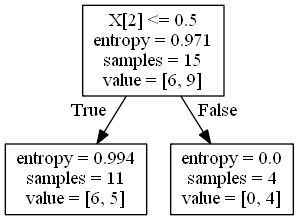

In [10]:
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image, display
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

# Create a string buffer to write to (a fake text file)
f = StringIO()

# Write the tree description data to the file
tree.export_graphviz(clf, out_file=f, proportion=False)

# Produce a visulation from the file
graph = pydotplus.graph_from_dot_data(f.getvalue())

display(Image(graph.create_png()))

### Saving your tree image to a file

In [11]:
# Write visualisation to image file 
graph.write_png("decision_tree.png")

True

## Business Example<a id='example'></a>

Let's take a look at how you could use a decision tree to determine if someone will default on their loan or not

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

default = pd.read_csv("default.csv")

default = pd.get_dummies(default)

y = default['default']

X = default.iloc[:, 1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

You may have noticed that in this dataset there are very few cases where people default on their loans (most people pay their loans). So we can weight the default class more to improve classification results.

I've set the depth to 5 layers.

In [13]:
default_clf = tree.DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced')

default_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [14]:
print(default_clf.tree_.value[:, 0][0:2])

[[ 3750.          3750.        ]
 [ 3155.20446097   253.16455696]]


Let's visualise our tree

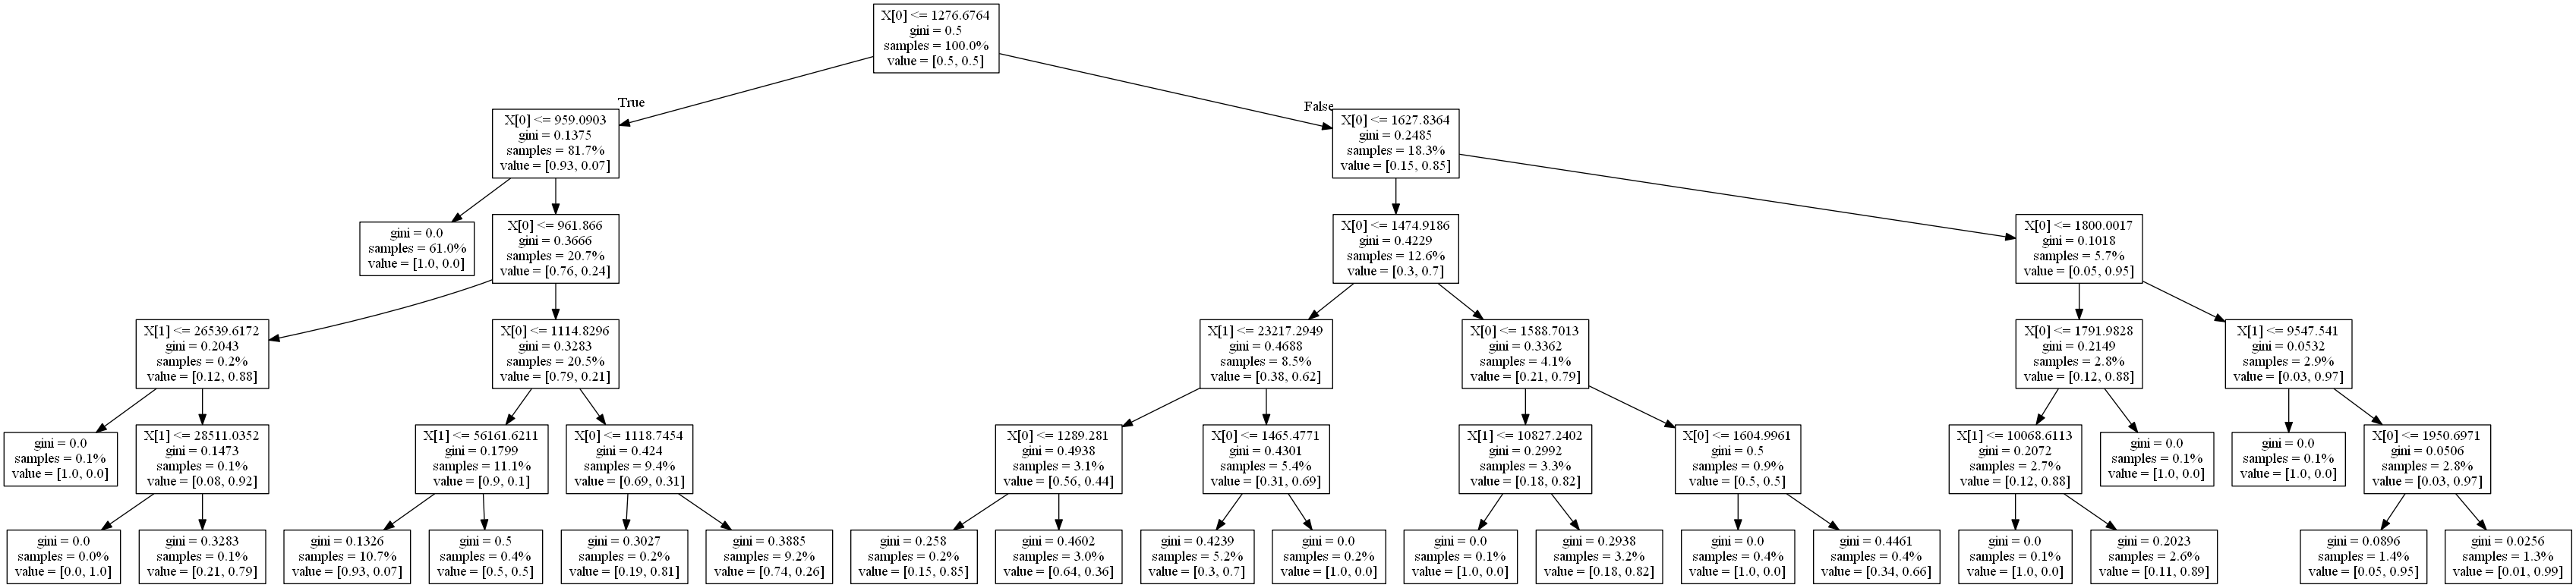

In [15]:
# Create a string buffer to write to (a fake text file)
f = StringIO()

# Write the tree description data to the file
tree.export_graphviz(default_clf, out_file=f, proportion=True)

# Produce a visulation from the file
graph = pydotplus.graph_from_dot_data(f.getvalue())

display(Image(graph.create_png()))

In [16]:
# Write visualisation to image file 
graph.write_png("decision_tree_default.png")

True

Now let's check the prediction accuracy

In [17]:
y_pred = default_clf.predict(X_test)

print("Number of defaults in test set: {0}".format(sum(y_test)))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

Number of defaults in test set: 96
[[2109  295]
 [  16   80]]
             precision    recall  f1-score   support

          0       0.99      0.88      0.93      2404
          1       0.21      0.83      0.34        96

avg / total       0.96      0.88      0.91      2500



### Discussion 

Like other methods you have already learnt about, decision trees have hyper parameters. The main parameter is the tree depth. You can try increase or decreasing the tree depth to see how it affects classification results.

**To pick the optimal depth you should use cross validation.**

The number of samples from each class also plays a roll in the success of our tree. I have shown you how you can apply more favourable weighting to a smaller class using the "balanced" class_weights option. How you weight your classes depends also on the application. In some areas you would prefer to be more conservative, i.e. prefer false positives rather than false negatives, for example in diagnosing patients or lending money. Your weighting scheme should reflect this.

## Installing Graphviz and Pydotplus<a id='graphviz'></a>

For this tutorial, you will need to install two libraries to visualise decison trees:
- graphviz
- pydotplus

### Windows:
1. Download and install graphviz http://www.graphviz.org/pub/graphviz/stable/windows/graphviz-2.38.msi
2. Add graphviz to your PATH environment variable
    1. Go to Computer > Properties > Advanced system settings> Environment Variables and then find "Path" in the system variables box. Click on Path and click edit.
    2. Append "C:\ProgramFiles(x86)\Graphviz2.38\bin" to the end of the many paths that are already present in Path.
3. Type the following commands on windows command prompt
    1. pip install graphviz
    2. conda install -c conda-forge pydotplus

If you see error "pip is not recognized as an internal or external command" when using "pip", you may refer to the following video.
http://mycodingzone.net/blogpost/english/pip-is-not-recognized-as-an-internal-or-external-command

If you see error "conda is not recognized as an internal or external command" when using "pip", refer to the document attached in tutorial material to see how to use Anaconda command promot to run "conda"

If you see error "InvocationException: GraphViz's executables not found", you may run below code in Python:

import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


### Mac OS X:
1. Type the following on the terminal
    1. pip install graphviz
    2. conda install graphviz
    3. conda install -c conda-forge pydotplus